In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt,spectrogram

In [3]:
# Low-pass filter configuration
cutoff_freq = 10  # Hz
T=.004 #seconds, from DAQ
sampling_rate = 1/T
nyquist_rate = sampling_rate / 2.0
b, a = butter(4, cutoff_freq / nyquist_rate, btype='low')

sampling_rate

250.0

In [4]:
csv_files = ['20241105_Bike_Testing/20241105_MLO_B_DCI.csv',
            '20241105_Bike_Testing/20241105_MLO_B_DCV.csv',

            '20241105_Bike_Testing/20241105_MLO_B_DCI2.csv',
            '20241105_Bike_Testing/20241105_MLO_B_DCV2.csv',

            '20241105_Bike_Testing/20241105_MLO_W_DCI.csv',
            '20241105_Bike_Testing/20241105_MLO_W_DCV.csv',

            '20241105_Bike_Testing/20241105_MLO_W_DCI2.csv',
            '20241105_Bike_Testing/20241105_MLO_W_DCV2.csv',
            
            '20241105_Bike_Testing/20241105_MLO_Y_DCI.csv',
            '20241105_Bike_Testing/20241105_MLO_Y_DCV.csv']


# titles = ["Test 1: MLO-B Current", "Test 2: MLO-B Voltage", "S2 Current", "S2 Voltage"]
titles = [fn[35:-4] for fn in csv_files]

T=.004
dfs=[]
for i, file in enumerate(csv_files):
    df = pd.read_csv(file, header=None, skiprows=4)
    df.drop(df.columns[[2,4,6]], axis=1, inplace=True)
    df.columns = ['Time', 'A0', 'A1','A2','A3']
    df.drop(columns=['A0','A2', 'A3'], axis=1, inplace=True)
    df['A1_filt'] = filtfilt(b, a, df['A1']) # Apply LP filter
    df.loc[df['Time'] < 0.5, 'A1_filt'] = None #remove first 0.5 seconds of data to avoid filter transients
    dfs.append(df)

len(dfs)

10

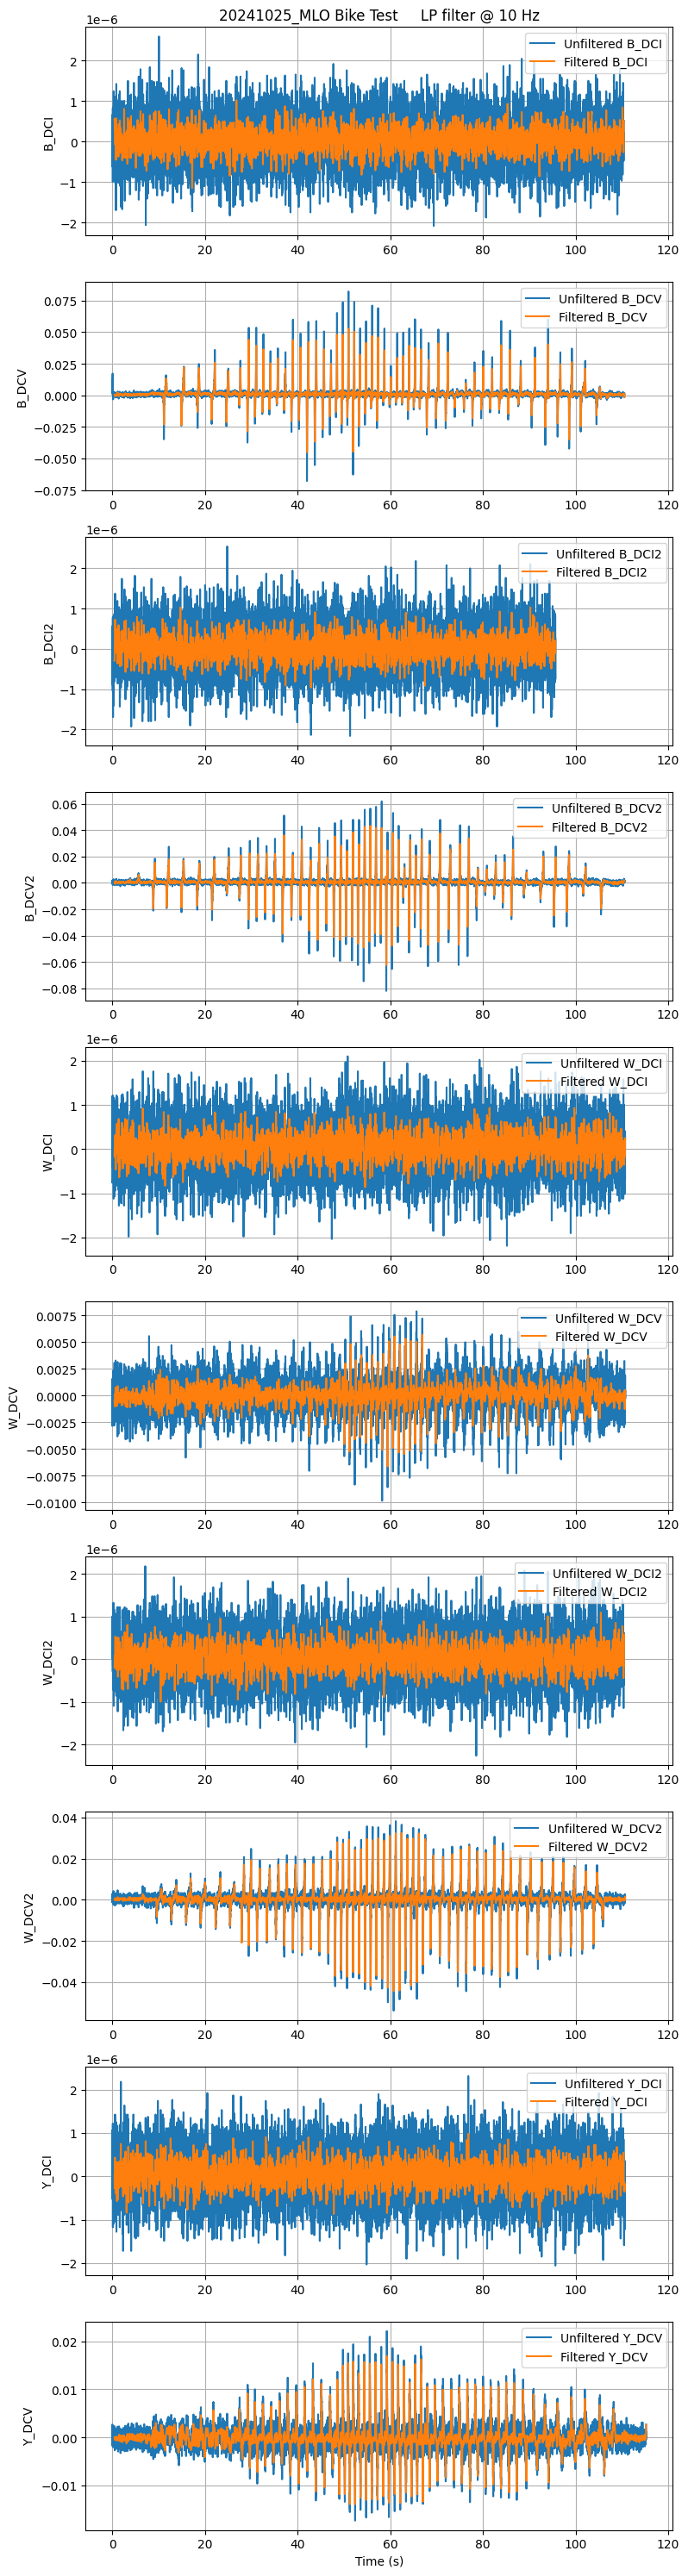

In [5]:
fig, axs = plt.subplots(len(dfs), 1, figsize=(8, 3*len(dfs)), sharex=True)
for i, df in enumerate(dfs):
    axs[i].plot(df['Time'], df['A1'], label='Unfiltered '+titles[i])
    axs[i].plot(df['Time'], df['A1_filt'], label='Filtered '+titles[i])
    axs[i].set_ylabel(titles[i])
    axs[i].legend(loc='upper right')
    axs[i].grid()
    axs[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)


axs[-1].set_xlabel('Time (s)')
axs[0].set_title(f"20241025_MLO Bike Test     LP filter @ {cutoff_freq} Hz")


plt.tight_layout()
plt.show()

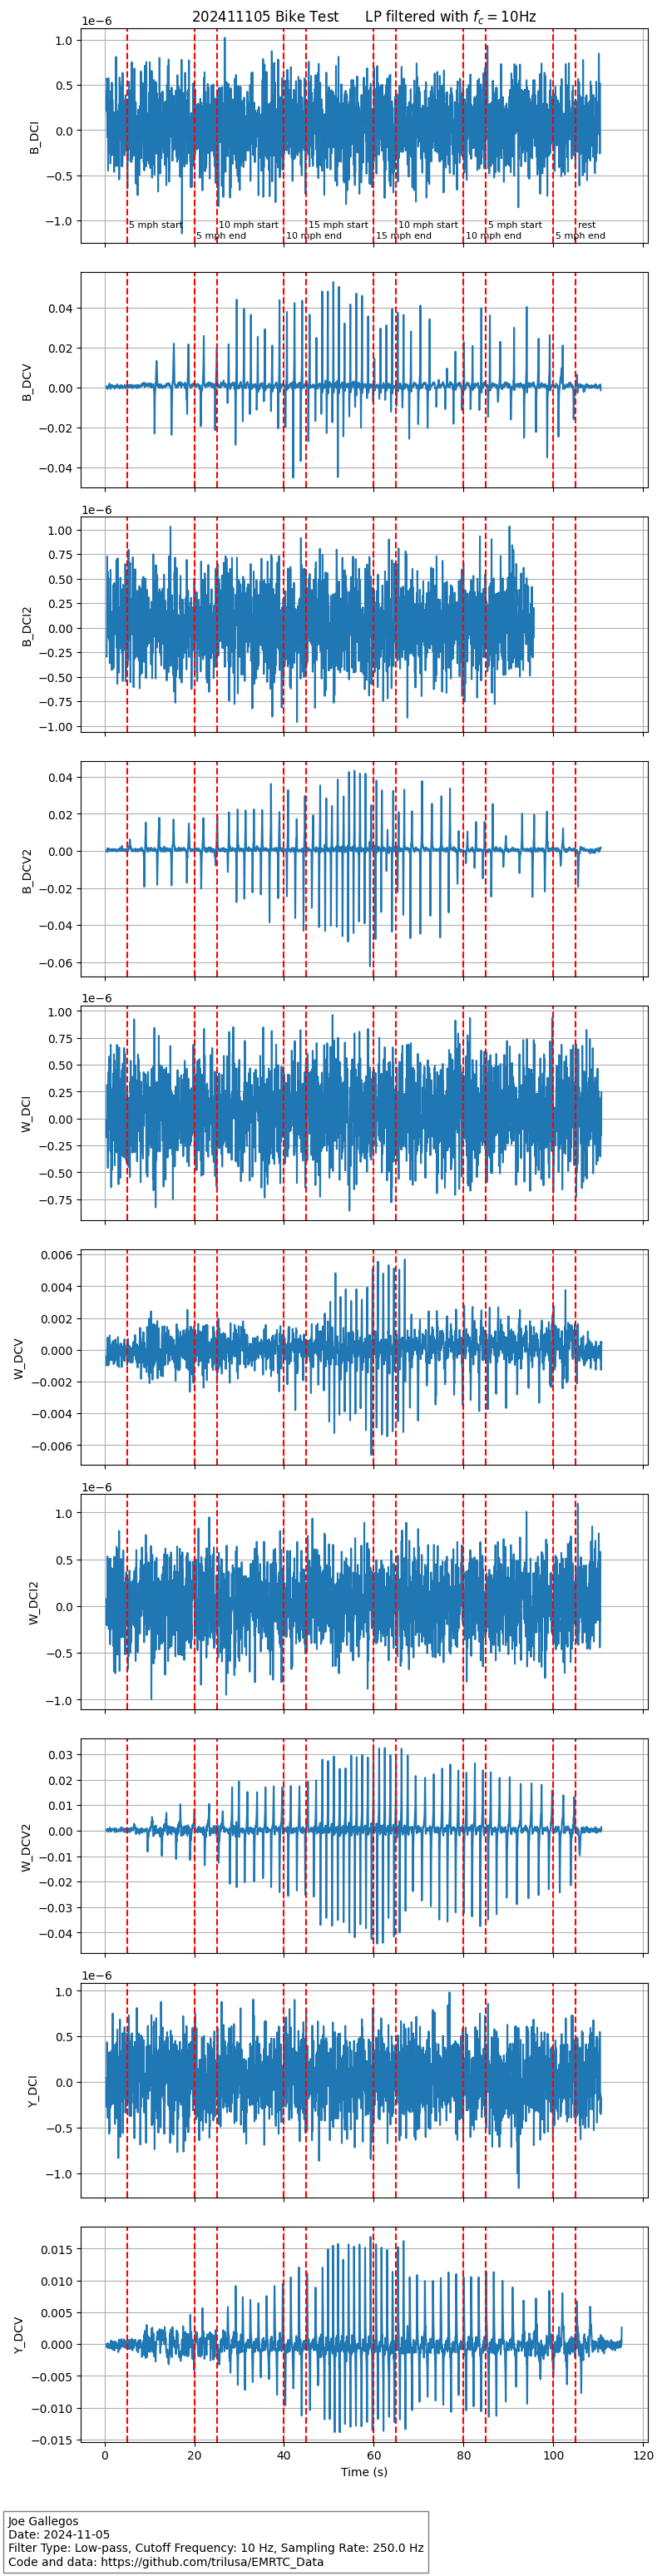

In [6]:
#Test speed ranges: 5, 10 and 15 mph
# 5 seconds to change speed, 15 seconds at each speed, all the way up and back down.
# 5 seconds rest before stopping data collection.

events = [[(5, "5 mph start"),
          (20, "5 mph end"),
          (25, "10 mph start"),
          (40, "10 mph end"),
          (45, "15 mph start"),
          (60, "15 mph end"),
          (65, "10 mph start"),
          (80, "10 mph end"),
          (85, "5 mph start"),
          (100, "5 mph end"),
          (105, "rest")] for df in dfs]

fig, axs = plt.subplots(len(dfs), 1, figsize=(8,3*len(dfs)), sharex=True)



for i, (df, event_list) in enumerate(zip(dfs, events)):
    axs[i].plot(df['Time'], df['A1_filt'], label=titles[i])
    axs[i].set_ylabel(titles[i])
    for j,(time, description) in enumerate(event_list):
        axs[i].axvline(x=time, color='r', linestyle='--')
        if i==0:
            axs[i].text(time+.5, axs[i].get_ylim()[0] - axs[i].get_ylim()[0] * (.2 if j%2==0 else .1), description, rotation=0, verticalalignment='top', fontsize=8)
    axs[i].grid()
axs[-1].set_xlabel('Time (s)')
axs[0].set_title(f"202411105 Bike Test\t LP filtered with $f_c={cutoff_freq}$Hz")
# plt.xlim(.5,65.5)


# Add metadata as a textbox below the plot
metadata = f'''Joe Gallegos
Date: 2024-11-05
Filter Type: Low-pass, Cutoff Frequency: {cutoff_freq} Hz, Sampling Rate: {sampling_rate} Hz
Code and data: https://github.com/trilusa/EMRTC_Data'''
bbox_props = dict(facecolor='white', alpha=0.5)
fig.subplots_adjust(bottom=.25)  # Adjust bottom space to fit the textbox
fig.text(0.01, -0.01, metadata, ha='left', va='top', fontsize=10, bbox=bbox_props)

plt.tight_layout()
plt.savefig("20241105_MLO_Bike_Test_annotated_timeseries.pdf", bbox_inches='tight')
plt.show()


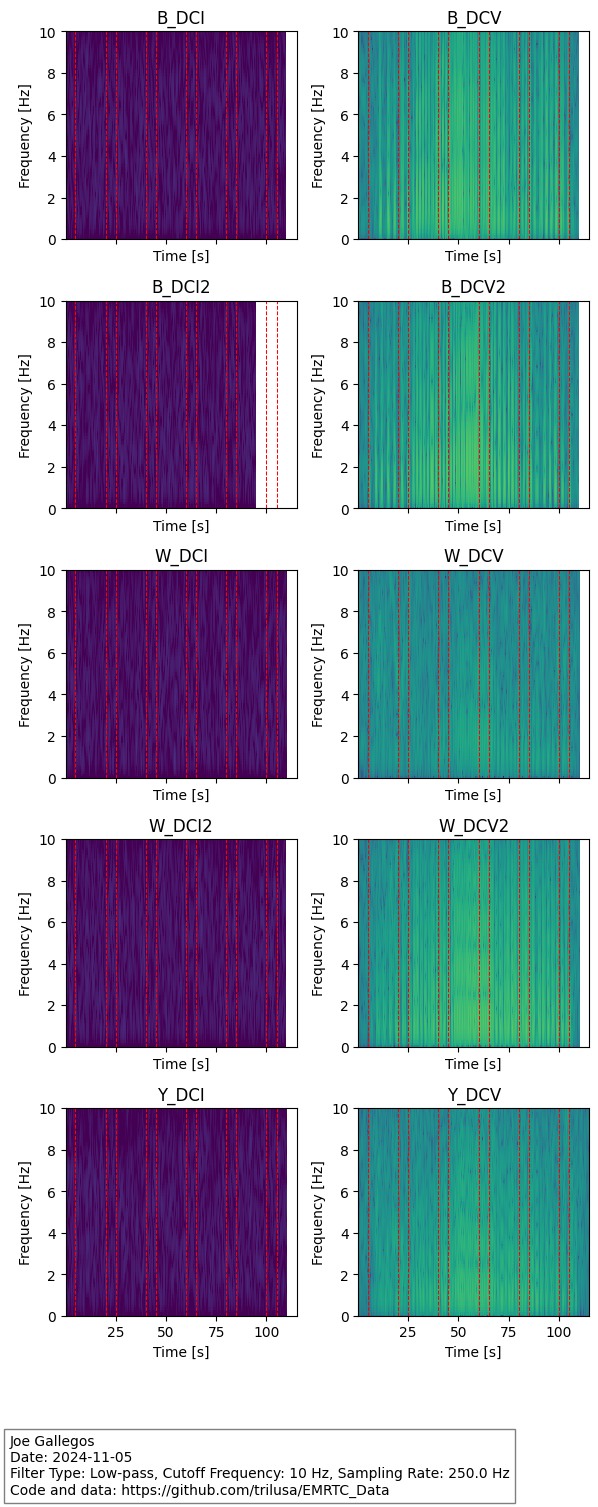

In [10]:
### Spectrogram ###
fig, axs = plt.subplots(len(dfs)//2, 2, figsize=(6,3*len(dfs)/2), sharex=True, sharey=False)
ax_flat = axs.flatten()

for i, (df, event_list) in enumerate(zip(dfs, events)):
    f, t, Sxx = spectrogram(df['A1_filt'], fs=sampling_rate, nperseg=256, noverlap=128, nfft=512*4)
    ax_flat[i].pcolormesh(t, f, 10 * np.log10(Sxx), shading='nearest', vmin=-150, vmax=0)
    # ax_flat[i].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    ax_flat[i].set_ylabel('Frequency [Hz]')
    ax_flat[i].set_xlabel('Time [s]')
    ax_flat[i].set_title(titles[i])
    ax_flat[i].set_ylim(0, 10)
    for time, description in event_list:
        ax_flat[i].axvline(x=time, color='r', linestyle='--', linewidth=.75)
        # ax_flat[i].text(time + 0.5, f.max() * 0.8, description, rotation=90, verticalalignment='top', fontsize=8, color='black')

fig.suptitle("Spectrograms of MLO Bike Test", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


bbox_props = dict(facecolor='white', alpha=0.5)
fig.text(0.01, -0.01, metadata, ha='left', va='top', fontsize=10, bbox=bbox_props)

# pdf not working, saved as png manually....
# plt.savefig("20241105_MLO_Bike_Test_annotated_spectrograms.pdf", bbox_inches='tight')
# plt.show()